#데이터 정보
- Auction_key : 경매 아파트 고유 키값
- Auction_class : 경매구분 (강제 경매 / 임의 경매) **
- Bid_class : 입찰구분(일반/개별/일괄) **
- Claim_price : 경매 신청인의 청구 금액
- Appraisal_company : 감정사 **
- Appraisal_date : 감정일자
- Auction_count : 총 경매 횟수
- Auction_miscarriage_count : 총 유찰 횟수
- Total_land_gross_area : 총토지전체면적(㎡)
- Total_land_real_area : 총토지실면적(㎡)
- Total_land_auction_area : 총토지경매면적(㎡)
- Total_building_area : 총건물면적(㎡)
- Total_building_auction_area : 총건물경매면적(㎡)
- Total_appraisal_price : 총감정가
- Minimum_sales_price : 최저매각가격, 입찰 시 입찰인이 최저로 제시해야만 하는 금액
- First_auction_date : 최초경매일
*   Final_auction_date : 최종경매일
* Final_result : 최종결과
* Creditor : 채권자, 경매 신청인 **
* addr_do : 주소_시도 **
* addr_si :주소_시군구 **
* addr_dong : 주소_읍면동 **
* addr_li ** (대부분 Nan값)
* addr_san : 주소_산번지 여부(Y) 
* addr_bunji1
* addr_bunji2
* addr_etc
* Apartment_usage : 건물(토지)의 대표 용도
* Completion_date : 준공일
* Preserve_regist_date : 보존등기일, 건물을 신축하고 처음으로 등기
* Total_floor : 총층수
* Current_floor : 현재층수
* Specific : 기타_특이사항
* Share_auction_YorN : 지분경매 여부(Y), 하나의 부동산이 전체가 아닌 일부만 경매가 진행
* road_name
* road_bunji1
* road_bunji2
* Close_date : 종국일자 -> 종국X -> 날짜가 1111-11-11
* Close_result : 종국결과
* point.y : 위도
* point.x : 경도
* Hammer_price : 낙찰가

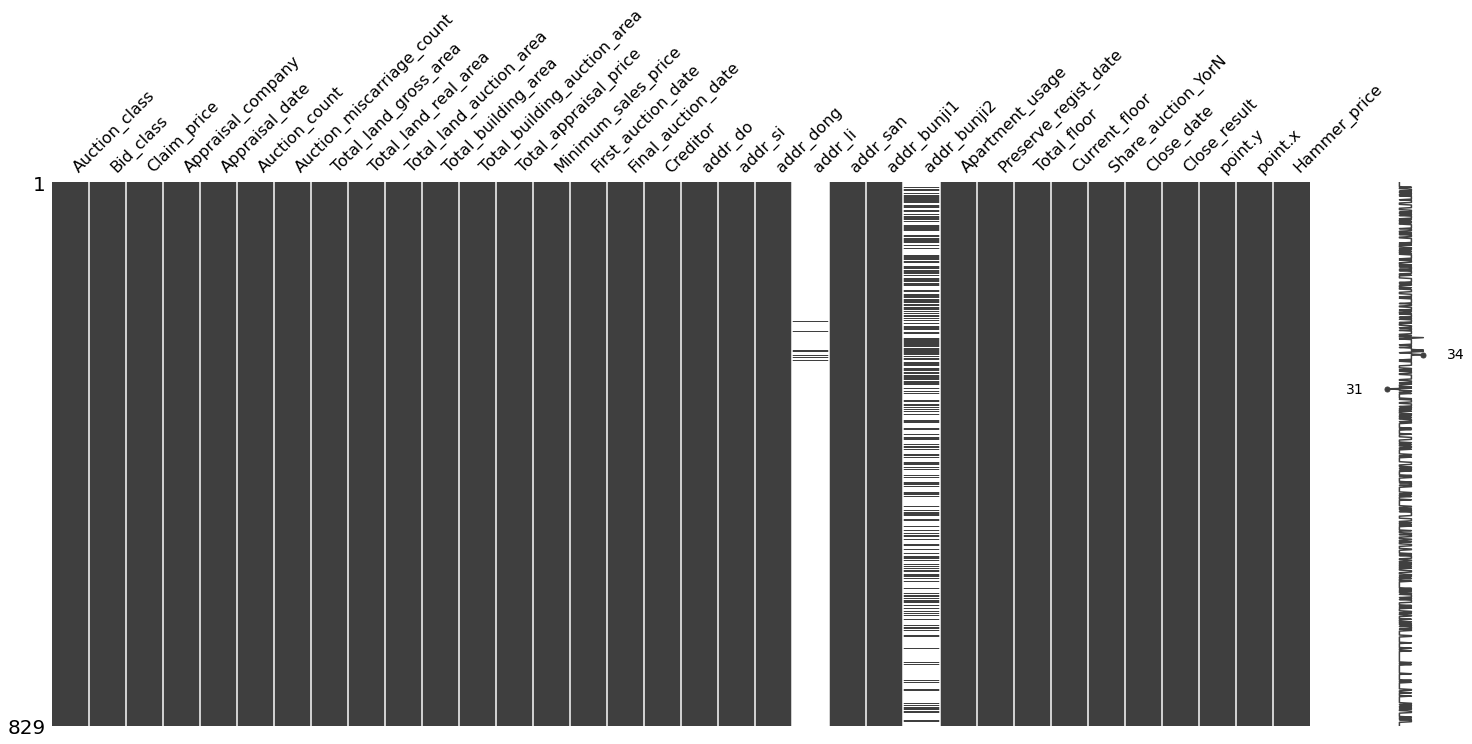

In [ ]:
import missingno as msno
msno.matrix(test)

- train 1933 rows × 41 columns
- test  829 rows × 41 columns (Hammer_price : 낙찰가 = 0)

#데이터 전처리
- Final_result : 최종 결과 모두 낙찰이므로 행 삭제

In [1]:
!unzip Auction_master_kr.zip

Archive:  Auction_master_kr.zip
  inflating: Auction_rent.csv        
   creating: __MACOSX/
  inflating: __MACOSX/._Auction_rent.csv  
  inflating: Auction_submission.csv  
  inflating: __MACOSX/._Auction_submission.csv  
  inflating: Auction_master_test.csv  
  inflating: __MACOSX/._Auction_master_test.csv  
  inflating: Auction_master_train.csv  
  inflating: __MACOSX/._Auction_master_train.csv  
  inflating: Auction_regist.csv      
  inflating: __MACOSX/._Auction_regist.csv  
  inflating: Auction_result.csv      
  inflating: __MACOSX/._Auction_result.csv  


In [98]:
import pandas as pd
train = pd.read_csv("Auction_master_train.csv")
test = pd.read_csv("Auction_master_test.csv")

In [99]:
print(train["Close_result"].value_counts())
print(train["addr_san"].value_counts())


배당      1921
          12
Name: Close_result, dtype: int64
N    1912
Y      21
Name: addr_san, dtype: int64


In [100]:
print(train.Final_result.unique())
print(test.Final_result.unique())
del train["Final_result"]
del test["Final_result"]
print(train.shape)

['낙찰']
['낙찰']
(1933, 40)


In [101]:
#addr_etc 행 제거 -> 위도 경도에서 정확한 위치 내포
# 도로명주소 제거 -> 번지 주소가 있음 
del train["addr_etc"]
del test["addr_etc"]

del train["road_name"]
del test["road_name"]

del train["road_bunji1"]
del test["road_bunji1"]

del train["road_bunji2"]
del test["road_bunji2"]

In [102]:
#Specific(기타사항)행 제거
del train["Specific"]
del test["Specific"]

#Auction_key 행 제거
del train["Auction_key"]
del test["Auction_key"]

#번지 자세한 주소가 큰 관여 할 것 같지 않음 (추측)
del train["addr_bunji1"]
del test["addr_bunji1"]

del train["addr_bunji2"]
del test["addr_bunji2"]

#채권자, 매우 다양하기 때문에 삭제
del train["Creditor"]
del test["Creditor"]

#주소 산번지 여부, 거의다 N
del train["addr_san"]
del test["addr_san"]

#종국 결과, 대부분 배당
del train["Close_result"]
del test["Close_result"]

#총건물면적(㎡) 삭제
del train["Total_building_area"]
del test["Total_building_area"]

#Total_land_gross_area : 총토지전체면적(㎡) 삭제
del train["Total_land_gross_area"]
del test["Total_land_gross_area"]

#Total_land_real_area : 총토지실면적(㎡) 삭제
del train["Total_land_real_area"]
del test["Total_land_real_area"]

#Minimum_sales_price 삭제 
del train["Minimum_sales_price"]
del test["Minimum_sales_price"]

print(train.shape)

(1933, 25)


In [103]:
#위도 경도 삭제 --> 상관계수가 addr_dong 과 1
train_x = train.loc[:, "Auction_class": "Close_date"]
train_y = train["Hammer_price"]
test_x = test.loc[:, "Auction_class": "Close_date"]

In [104]:
#동+리

notnull_test = [212, 227, 231, 237, 256, 258, 263, 264, 267, 269, 272]
notnull_train_x = [46,  63,  72,  93, 103, 110, 181, 214, 249, 324, 336, 339, 340, 346, 411, 414, 456, 473, 550, 612, 618, 635, 639]

#train
addr_dong = train_x.loc[:, "addr_dong"]

for i in notnull_train_x:
  dongli = train_x.loc[i]["addr_dong"]+train_x.loc[i]["addr_li"]
  addr_dong[i] = dongli

train_x["addr_dong"] = addr_dong

#test
addr_dong = test_x.loc[:, "addr_dong"]

for i in notnull_test:
  dongli = test_x.loc[i]["addr_dong"]+test_x.loc[i]["addr_li"]
  addr_dong[i] = dongli

test_x["addr_dong"] = addr_dong

del train_x["addr_li"]
del test_x["addr_li"]
print(train_x.shape)

(1933, 21)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [105]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder() #"Appraisal_company"
label = ["Auction_class", "Bid_class", "Apartment_usage", "addr_do", "addr_si", "Share_auction_YorN"]


for i in label :
  train_x[i] = le.fit_transform(train_x[i])
  test_x[i] = le.transform(test_x[i])

train_x["Appraisal_company"] = le.fit_transform(train_x["Appraisal_company"])
test_le_list = list(le.classes_ )
not_append = ['LH감정', '밝은숲감정', '새날감정', '성우감정', '씨티감정', '아람감정', '정우감정', '정인제감정', '청림감정']
test_le_list.extend(not_append)
le.fit(test_le_list)
test_x["Appraisal_company"] = le.transform(test_x["Appraisal_company"])


train_x["addr_dong"] = le.fit_transform(train_x["addr_dong"])
test_le_list = list(le.classes_ )
not_append = ['궁동', '금호동1가', '금호동3가', '금호동4가','기장읍청강리', '대현동', '문래동4가','보문동3가', '봉래동5가', '삼락동', '송정동', '신공덕동', '신창동1가', '신호동', '양평동3가', 
              '양평동4가', '염리동', '영등포동5가', '용산동5가', '자곡동','장충동1가','청룡동','충무동2가', '한강로1가','합정동','후암동']
test_le_list.extend(not_append)
le.fit(test_le_list)
test_x["addr_dong"] = le.transform(test_x["addr_dong"])

In [106]:
#날짜 형식(년월일시간) -----> 년.월 로 변경

import numpy as np
import datetime


df = pd.DataFrame({'Appraisal_date': pd.to_datetime(train_x['Appraisal_date'])},index=train_x.index)
df['Appraisal_dateYM'] = df['Appraisal_date'].dt.year + (df['Appraisal_date'].dt.month * 0.01)
train_x['Appraisal_date'] = df['Appraisal_dateYM']

df = pd.DataFrame({'First_auction_date': pd.to_datetime(train_x['First_auction_date'])},index=train_x.index)
df['First_auction_dateYM'] = df['First_auction_date'].dt.year + (df['First_auction_date'].dt.month * 0.01)
train_x['First_auction_date'] = df['First_auction_dateYM']

df = pd.DataFrame({'Final_auction_date': pd.to_datetime(train_x['Final_auction_date'])},index=train_x.index)
df['Final_auction_dateYM'] = df['Final_auction_date'].dt.year + (df['Final_auction_date'].dt.month * 0.01)
train_x['Final_auction_date'] = df['Final_auction_dateYM']


df = pd.DataFrame({'Appraisal_date': pd.to_datetime(test_x['Appraisal_date'])},index=train_x.index)
df['Appraisal_dateYM'] = df['Appraisal_date'].dt.year + (df['Appraisal_date'].dt.month * 0.01)
test_x['Appraisal_date'] = df['Appraisal_dateYM']

df = pd.DataFrame({'First_auction_date': pd.to_datetime(test_x['First_auction_date'])},index=train_x.index)
df['First_auction_dateYM'] = df['First_auction_date'].dt.year + (df['First_auction_date'].dt.month * 0.01)
test_x['First_auction_date'] = df['First_auction_dateYM']

df = pd.DataFrame({'Final_auction_date': pd.to_datetime(test_x['Final_auction_date'])},index=train_x.index)
df['Final_auction_dateYM'] = df['Final_auction_date'].dt.year + (df['Final_auction_date'].dt.month * 0.01)
test_x['Final_auction_date'] = df['Final_auction_dateYM']




#1111-11-11 00:00:00 형으로 아래 두개의 행은 삭제하도록 한다.

del train_x["Preserve_regist_date"]
del test_x["Preserve_regist_date"]

del train_x["Close_date"]
del test_x["Close_date"]

#df = pd.DataFrame({'Preserve_regist_date': pd.to_datetime(train_x['Preserve_regist_date'])},index=train_x.index)
#df['Preserve_regist_dateYM'] = df['Preserve_regist_date'].dt.year + (df['Preserve_regist_date'].dt.month * 0.01)
#train_x['Preserve_regist_date'] = df['Preserve_regist_dateYM']

#df = pd.DataFrame({'Close_date': pd.to_datetime(train_x['Close_date'])},index=train_x.index)
#df['Close_dateYM'] = df['Close_date'].dt.year + (df['Close_date'].dt.month * 0.01)
#train_x['Close_date'] = df['Close_dateYM']

In [107]:
train_x

,Auction_class,Bid_class,Claim_price,Appraisal_company,Appraisal_date,Auction_count,Auction_miscarriage_count,Total_land_auction_area,Total_building_auction_area,Total_appraisal_price,First_auction_date,Final_auction_date,addr_do,addr_si,addr_dong,Apartment_usage,Total_floor,Current_floor,Share_auction_YorN
0,1,0,1766037301,181,2017.07,2,1,37.35,181.77,836000000,2018.02,2018.03,0,38,208,1,45,5,0
1,1,2,152946867,237,2016.09,2,1,18.76,118.38,1073000000,2016.12,2017.02,0,38,208,0,70,51,0
2,1,0,11326510,233,2016.11,3,2,71.00,49.94,119000000,2017.07,2017.10,0,20,91,0,15,14,0
3,1,2,183581724,128,2016.12,2,1,32.98,84.91,288400000,2017.07,2017.11,0,10,61,0,20,11,0
4,0,2,45887671,46,2016.03,2,1,45.18,84.96,170000000,2016.07,2016.08,0,21,21,0,7,7,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1928,0,2,280000000,99,2017.02,1,0,40.55,84.87,401000000,2017.06,2017.06,1,12,251,0,21,15,0
1929,1,2,200000000,95,2015.02,2,1,39.60,114.81,454000000,2017.02,2017.03,1,11,133,0,23,23,0
1930,1,2,354805459,107,2016.10,2,1,19.03,133.98,1285000000,2017.12,2018.01,1,36,285,1,32,19,0
1931,0,2,80000000,222,2016.06,2,1,42.20,84.94,407000000,2016.10,2016.11,1,12,172,0,15,11,0


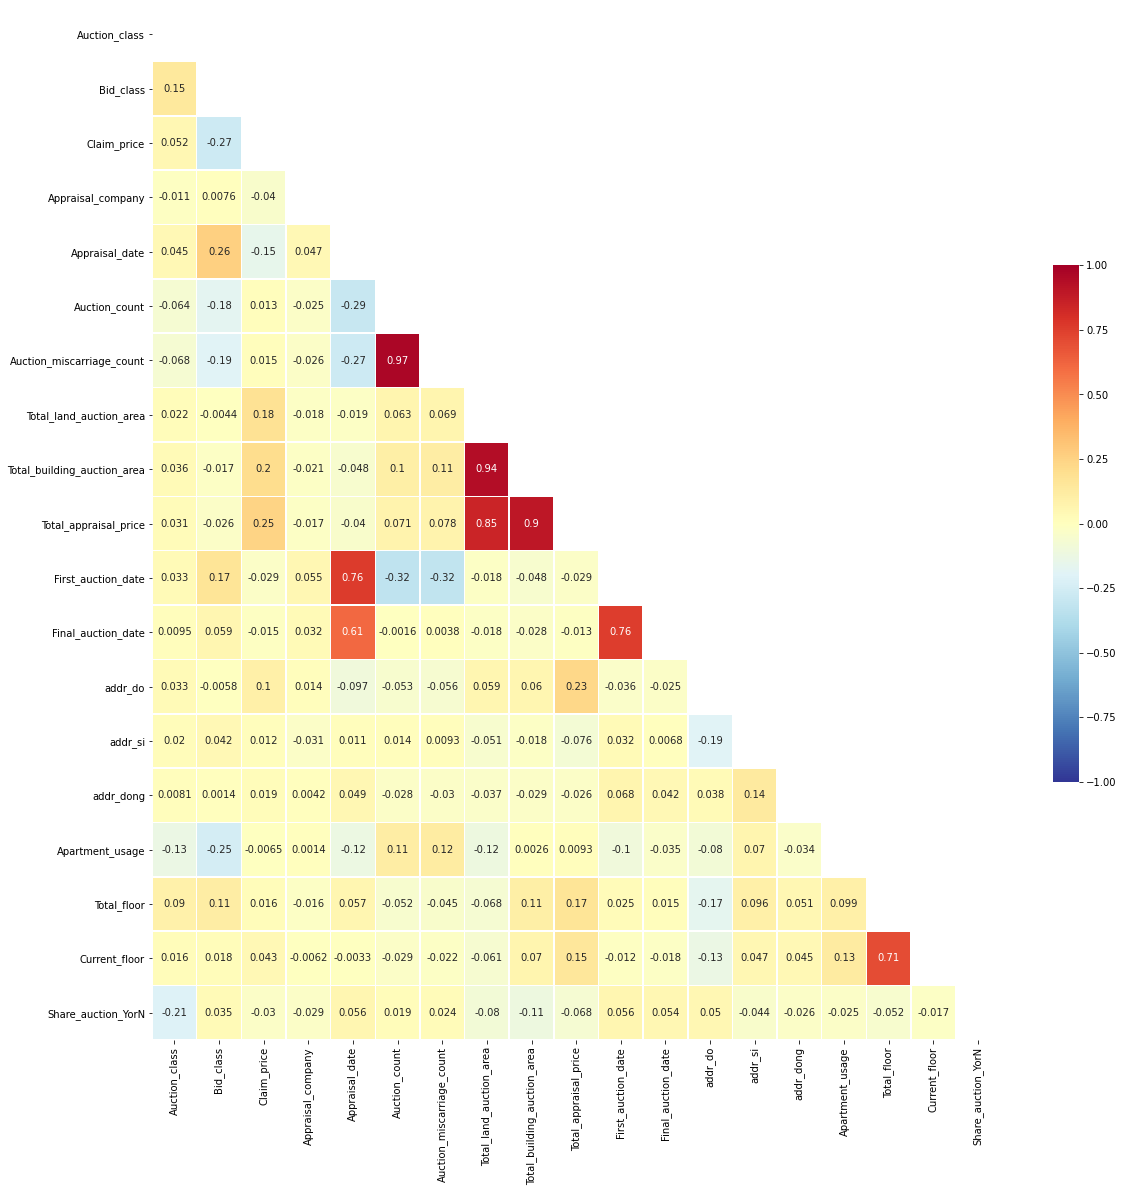

In [108]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = train_x.corr()
# 그림 사이즈 지정
fig, ax = plt.subplots( figsize=(19,19) )

# 삼각형 마스크를 만든다(위 쪽 삼각형에 True, 아래 삼각형에 False)
mask = np.zeros_like(df, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# 히트맵을 그린다
sns.heatmap(df, 
            cmap = 'RdYlBu_r', 
            annot = True,   # 실제 값을 표시한다
            mask=mask,      # 표시하지 않을 마스크 부분을 지정한다
            linewidths=.5,  # 경계면 실선으로 구분하기
            cbar_kws={"shrink": .5},# 컬러바 크기 절반으로 줄이기
            vmin = -1,vmax = 1   # 컬러바 범위 -1 ~ 1
           )  
plt.show()


#데이터 정규화

In [62]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
x_train_std = scaler.fit_transform(train_x)
x_test_std = scaler.transform(test_x)

# 모델 학습

In [113]:
import torch
import torch.optim as optim
import numpy as np

torch.manual_seed(1)

x_data = np.array(x_train_std)
y_data = np.array(train_y)

x_train = torch.FloatTensor(x_data)
y_train = torch.FloatTensor(y_data).unsqueeze(1)
y_train

tensor([[7.6000e+08],
        [9.7189e+08],
        [9.3400e+07],
        ...,
        [1.1190e+09],
        [4.0300e+08],
        [6.8601e+08]])

In [115]:
W = torch.zeros((19, 1), requires_grad= True)
b = torch.zeros(1, requires_grad= True)

optimizer = optim.SGD([W, b], lr = 1e-2)

nb_epochs = 19000

for epoch in range(nb_epochs + 1):
  hypothesis = x_train.matmul(W) + b
  cost = torch.mean((hypothesis - y_train)**2)

  optimizer.zero_grad()
  cost.backward()
  optimizer.step()

  if epoch%1000 == 0:
    print(epoch, cost.item())

0 5.340249292307169e+17
1000 2.4575789123816653e+17
2000 2.2510725898226893e+17
3000 2.1002405539322266e+17
4000 1.9756521426098586e+17
5000 1.866374946100347e+17
6000 1.767903200112804e+17
7000 1.6780961211482112e+17
8000 1.5957315333128192e+17
9000 1.5199736359708262e+17
10000 1.450168906898473e+17
11000 1.3857675043825254e+17
12000 1.3262885638845235e+17
13000 1.2713029322722509e+17
14000 1.2204263817714074e+17
15000 1.1733111918297088e+17
16000 1.129642970841088e+17
17000 1.089137048373166e+17
18000 1.0515338366025728e+17
19000 1.0165990880129843e+17


In [116]:
x_test = torch.FloatTensor(np.array(x_test_std))

predict = (x_test.matmul(W)+b).detach()

submit = pd.read_csv("Auction_submission.csv")

for i in range(len(predict)):
  submit["Hammer_price"][i] = predict[i]

submit.to_csv("submission.csv", index = False, header = True)

#성능 287570729.7383769	